# Assembly and analysis of Ficus RAD-seq data

A library for 96 samples was prepared by Floragenex with the PstI restriction enzyme, followed by sonication and size selection. Stats reported by Floragenex include: AverageFragmentSize=386bp, Concentration=2.51ng/uL, Concentation=10nM. The library was sequenced on two lanes of Illumina HiSeq 3000 yielding 378,809,976 reads in lane 1, and 375,813,513 reads in lane 2, for a total of ~755M reads.  

### _de novo_ assembly with ipyrad
This notebook provides a fully reproducible workflow to assemble this data set with ipyrad. Starting from the raw data files, we demultiplex and filter reads, then cluster within samples to identify homology. Next we call consensus sequences and then cluster across samples to identify orthologs. Finally we apply more filters to remove paralogs and poor alignments, and create output files. 

In [1]:
import ipyrad as ip
print 'ipyrad v.{}'.format(ip.__version__)

ipyrad v.0.4.4


### The raw data
The data came to us as two large 20GB files. The barcodes file was provided by Floragenex and maps sample names to barcodes that are contained inline in the sequences, and are 10bp in length. The barcodes are printed a little further below. I ran the program *fastQC* on the raw data files to do a quality check, the results of which are available here [lane1-fastqc](link) and here [lane2-fastqc](link). Overall, quality scores were very high and there was little (but some) adapter contamination, which we will filter out in the ipyrad analysis. 

In [2]:
## Locations of the raw data and barcodes file
lane1data = "~/Documents/RADSEQ_DATA/Ficus/Ficus-1_S1_L001_R1_001.fastq.gz"
lane2data = "~/Documents/RADSEQ_DATA/Ficus/Ficus-2_S2_L002_R1_001.fastq.gz"
barcodes = "~/Documents/RADSEQ_DATA/barcodes/Ficus_Jander_2016_95barcodes.txt"


### Create Assembly object for each demultiplexed lane in *ipyrad*
We set the location to the data and barcodes info for each object, and set the max barcode mismatch parameter to zero (strict), allowing no mismatches. 

In [3]:
## create an object to demultiplex each lane
demux1 = ip.Assembly("ficus_demux-lane1")
demux2 = ip.Assembly("ficus_demux-lane2")

## set basic derep parameters for the two objects
demux1.set_params("project_dir", "./demux_reads")
demux1.set_params("raw_fastq_path", lane1data)
demux1.set_params("barcodes_path", barcodes)
demux1.set_params("max_barcode_mismatch", 0)

demux2.set_params("project_dir", "./demux_reads")
demux2.set_params("raw_fastq_path", lane2data)
demux2.set_params("barcodes_path", barcodes)
demux2.set_params("max_barcode_mismatch", 0)

  New Assembly: ficus_demux-lane1
  New Assembly: ficus_demux-lane2


This is not required, but for prosperity's sake we'll print the barcodes here to make the info readily available.

In [4]:
## Link the barcodes to Samples and print the barcodes info
demux1._link_barcodes()

print "\nBarcodes info:"
for bar in sorted(demux1.barcodes):
    print "{:<16}\t{}".format(bar, demux1.barcodes[bar])


Barcodes info:
A01_paraensis   	GTATATCCAC
A02_paraensis   	CGTACCTTGC
A04_paraensis   	TATCGCGGAG
A05_paraensis   	CATGCATACT
A06_obtusifolia 	TTGATGGTGC
A07_obtusifolia 	CAACATGAAG
A16_citrifolia  	GTTGCTAGAC
A18_citrifolia  	AATAGATTCA
A19_citrifolia  	AGCTGATACA
A26_popenoei    	CGGTCGTTAC
A27_popenoei    	GACGGACAGG
A28_popenoei    	ATTGCCACCG
A29_popenoei    	CAGAACCAGC
A33_nymphaeifolia	ACTTGACCGG
A34_nymphaeifolia	AATGGTGACT
A38_nymphaeifolia	CTAACAGTAT
A41_nymphaeifolia	TCATAGGCTA
A42_nymphaeifolia	GCTGCACGGT
A48_trigonata   	AAGACCAATC
A49_trigonata   	ACTGCCTCAA
A55_triangle    	CTTACCGGAG
A59_dugandii    	AGTTCCATTG
A60_dugandii    	TTCTTGCGCT
A61_turbinata   	CAAGAGACGT
A62_turbinata   	GCACGTCTCC
A63_turbinata   	GTGCTCTCTA
A65_pertusa     	AGACGAATAG
A67_bullenei    	TCCGGAGCGC
A69_bullenei    	CTAACACGGC
A70_bullenei    	AGCTTCGATT
A71_bullenei    	TCGCCGCAAT
A72_bullenei    	TCAGTTCCGG
A75_colubrinae  	GCTGTGCAGA
A77_colubrinae  	CAAGCCGGTT
A82_perforata   	TCACTGAGAA

### Run demultiplexing (step 1 of ipyrad) on both assemblies
I'm running this on a workstation, but it would run much faster on an HPC setup that has parallel I/O write abilities. 

In [5]:
## Now run demultiplexing for both assemblies
demux1.run("1")
demux2.run("1")


  Assembly: ficus_demux-lane1
  [####################] 100%  chunking large files  | 0:24:18 | s1 | 
  [####################] 100%  sorting reads         | 0:40:09 | s1 | 
  [####################] 100%  writing/compressing   | 0:32:14 | s1 | 

  Assembly: ficus_demux-lane2
  [####################] 100%  chunking large files  | 0:25:14 | s1 | 
  [####################] 100%  sorting reads         | 0:37:18 | s1 | 
  [####################] 100%  writing/compressing   | 0:34:58 | s1 | 


### The demultiplexed data
Now we have two directories with demultiplexed data, each with one gzipped fastq file corresponding to all of the reads matching to a particular Sample's barcode from that lane of sequencing. These are the data that we would typically upload to Genbank SRA when we publish. So below we'll set up our analysis as if we were starting from having just received these demultiplexed fastq files. Below a print some stats for how many reads matched to each Sample. It was pretty consistent between the two lanes of sequencing, and highly variable among Samples within each lane. This almost certainly has to do with the different quantity and quality of DNAs that we extracted. 

In [6]:
print demux1.stats

                        state  reads_raw
A01_paraensis               1     317609
A02_paraensis               1     477846
A04_paraensis               1    4860262
A05_paraensis               1     389527
A06_obtusifolia             1      69225
A07_obtusifolia             1      91014
A16_citrifolia              1     134536
A18_citrifolia              1     134654
A19_citrifolia              1     299331
A26_popenoei                1      74080
A27_popenoei                1     155366
A28_popenoei                1      57880
A29_popenoei                1      35892
A33_nymphaeifolia           1     354173
A34_nymphaeifolia           1     136369
A38_nymphaeifolia           1      74130
A41_nymphaeifolia           1    1314958
A42_nymphaeifolia           1    2905899
A48_trigonata               1    1799963
A49_trigonata               1     247619
A55_triangle                1     394126
A59_dugandii                1    1382146
A60_dugandii                1      88436
A61_turbinata   

### Create our first assembly object
We will join these two demultiplexed libraries into a single analysis that has the set of parameters we will use to assemble the data set. 


In [7]:
## named corresponding to some params we are changing
data = ip.merge("ficus_c85d6f2", [demux1, demux2])

## set several non-default parameters
data.set_params("project_dir", "analysis_ipyrad")
data.set_params("filter_adapters", 2)
data.set_params("trim_overhang", (0, 8, 0, 0))
data.set_params("max_Hs_consens", (5, 5))
data.set_params("max_shared_Hs_locus", 4)

## print parameters for prosperity's sake
data.get_params()

  0   assembly_name               ficus_c85d6f2                                
  1   project_dir                 ./analysis_ipyrad                            
  2   raw_fastq_path              /home/deren/Documents/RADSEQ_DATA/Ficus/Ficus-1_S1_L001_R1_001.fastq.gz
  3   barcodes_path               /home/deren/Documents/RADSEQ_DATA/barcodes/Ficus_Jander_2016_95barcodes.txt
  4   sorted_fastq_path                                                        
  5   assembly_method             denovo                                       
  6   reference_sequence                                                       
  7   datatype                    rad                                          
  8   restriction_overhang        ('TGCAG', '')                                
  9   max_low_qual_bases          5                                            
  10  phred_Qscore_offset         33                                           
  11  mindepth_statistical        6                             

### Total reads for each Sample from the two combined libraries?
As you can see it's quite variable. 

In [8]:
print data.stats

                        state  reads_raw
A01_paraensis               1     634119
A02_paraensis               1     956254
A04_paraensis               1    9708308
A05_paraensis               1     776829
A06_obtusifolia             1     136685
A07_obtusifolia             1     178331
A16_citrifolia              1     268947
A18_citrifolia              1     267657
A19_citrifolia              1     597157
A26_popenoei                1     146893
A27_popenoei                1     302250
A28_popenoei                1     113199
A29_popenoei                1      69802
A33_nymphaeifolia           1     702301
A34_nymphaeifolia           1     270651
A38_nymphaeifolia           1     147323
A41_nymphaeifolia           1    2628475
A42_nymphaeifolia           1    5812916
A48_trigonata               1    3593575
A49_trigonata               1     494929
A55_triangle                1     779208
A59_dugandii                1    2758710
A60_dugandii                1     175714
A61_turbinata   

### Filtering options
From looking closely at the data it appears there is a lot of poor quality reads with adapter contamination and long strings of poly repeats. It turns out our sequencing facility did not perform a qPCR before sequencing, which almost surely affected the resulting quantity due to overdispersion of the clusters. However, all hope is not lost, we can filter most of this junk out pretty well. Setting the filter parameter in ipyrad to strict (2) uses 'cutadapt' to filter the reads. By default ipyrad would look just for the Illumina common adapter (printed below), but since this is an extreme case I'm adding the primer sequence to the end of the adapter to do a more strict search. This primer can vary depending on your library prep, the sequence here was found from simply looking at the raw sequence data. I'm also telling it to trim poly-T repeats of 12 or more, since this appears common to the data set. 

In [9]:
## print the standard adapter checked in ipyrad
#print "standard check is for", data._hackersonly

## store full illumina common Illumina adapter+primer 
## this will be searched for and trimmed from reads
data._hackersonly["p3_adapter"] = \
    "AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGAACTCGTATGCCGTCTTCTGCTTG" 

## also trim poly-T repeats, which appear common in this data set.
## This will be a little overzealous in trimming terminal Ts, but 
## it's probably good to start out overly conservative w/ filtering.
data._hackersonly["p3_adapters_extra"] = ["TTTTTTTTTTTT"]
    
## print our new more strict adapter and seq to be trimmed
print "trimming sequences:"
print data._hackersonly["p3_adapter"]
print data._hackersonly["p3_adapters_extra"]

standard check is for OrderedDict([('random_seed', 42), ('max_fragment_length', 50), ('max_inner_mate_distance', 60), ('p5_adapter', 'AGATCGGAAGAGC'), ('p3_adapter', 'AGATCGGAAGAGC'), ('p3_adapters_extra', []), ('p5_adapters_extra', []), ('preview_step1', 4000000), ('preview_step2', 100000), ('output_loci_name_buffer', 5), ('query_cov', None), ('smalt_index_wordlen', 8)])
trimming sequences:
AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGAACTCGTATGCCGTCTTCTGCTTG
['TTTTTTTTTTTT']


### Now run ipyrad steps 2-5 to get consensus reads for each Sample
We'll look more closely at the stats for each step after it's finished. 

In [10]:
## run steps 2-5
data.run("2345")


  Assembly: ficus_c85d6f2
  [####################] 100%  concatenating inputs  | 0:05:46 | s2 | 
  [####################] 100%  processing reads      | 0:46:19 | s2 | 
  [####################] 100%  dereplicating         | 0:03:35 | s3 | 
  [####################] 100%  clustering            | 0:24:06 | s3 | 
  [####################] 100%  building clusters     | 0:00:55 | s3 | 
  [####################] 100%  chunking              | 0:00:03 | s3 | 
  [####################] 100%  aligning              | 0:56:40 | s3 | 
  [####################] 100%  concatenating         | 0:00:08 | s3 | 
  [####################] 100%  inferring [H, E]      | 1:55:03 | s4 | 
  [####################] 100%  consensus calling     | 0:31:48 | s5 | 


### Branch to remove the low data samples and FGX Control Sample
We have several Samples that recovered very little data, probably as a result of having low quality DNA extractions. Figs are hard. We'll assemble one data set that includes all of these samples (data1) but since they are likely to have little information we'll assemble most of our data sets with these low data samples excluded. We'll also exclude the Floragenex control sample, since that is just a quality check sample (I checked it, it looks like the rest). To exclude samples we need to create a new named branch. The idea behind this is that it keeps a record of the old assembly in case we want to go back to before we excluded these samples. 

In [11]:
## set a minimum value to exclude samples
minconsens = 500

## find which Samples have low data
lowdata = set(data.stats.index[data.stats.reads_consens < minconsens])

## make list of which Samples we should keep
keep = list(set(data.samples.keys()) - lowdata - set(["FGXCONTROL"]))

## branch and supply the keep list as an arg
sub1 = data.branch("ficus_c85d6f2_min4", keep)

## print how many taxa were excluded?
print "full data set has {} samples".format(len(data.samples))
print "sub1 data set has {} samples".format(len(sub1.samples))
print "\nthe following samples were dropped:"
for sample in data.samples:
    if sample not in sub1.samples:
        nconsens = data.samples[sample].stats.reads_consens
        print "  -{:<15}\t{}".format(sample, int(nconsens))

full data set has 96 samples
sub1 data set has 91 samples

the following samples were dropped:
  -C02_citrifolia 	32
  -C09_costaricana	126
  -C52_citrifolia 	173
  -FGXCONTROL     	6151
  -C34_triangle   	229


### Now we'll cluster consensus reads across Samples
We'll cluster the data set with and without the low data samples included, just so we can check how poorly the bad samples turn out. But we'll almost certainly want to exclude them, so we'll focus most of our results on the 'data2' Assembly, and its subsequent branches below, which have low data Samples removed. 


In [12]:
#data.run("6")
sub1.run("6")


  Assembly: ficus_c85d6f2_min4
  [####################] 100%  concat/shuffle input  | 0:00:43 | s6 | 
  [####################] 100%  clustering across     | 2:51:57 | s6 | 
  [####################] 100%  building clusters     | 0:00:37 | s6 | 
  [####################] 100%  aligning clusters     | 0:06:30 | s6 | 
  [####################] 100%  database indels       | 0:03:30 | s6 | 
  [####################] 100%  indexing clusters     | 0:09:17 | s6 | 
  [####################] 100%  building database     | 0:34:26 | s6 | 


### Create additional branches with different minSamp param settings

In [13]:
sub2 = sub1.branch("ficus_c85d6f2_min10")
sub2.set_params("min_samples_locus", 10)

sub3 = sub2.branch("ficus_c85d6f2_min20")
sub3.set_params("min_samples_locus", 20)

### Finish assembly of data sets

In [14]:
sub1.run("7")
sub2.run("7")
sub3.run("7")


  Assembly: ficus_c85d6f2_min4
  [####################] 100%  filtering loci        | 0:00:15 | s7 | 
  [####################] 100%  building loci/stats   | 0:00:08 | s7 | 
  [####################] 100%  building vcf file     | 0:02:38 | s7 | 
  [####################] 100%  writing vcf file      | 0:00:01 | s7 | 
  [####################] 100%  writing outfiles      | 0:00:59 | s7 | 
  Outfiles written to: ~/Documents/Ficus/analysis_ipyrad/ficus_c85d6f2_min4_outfiles

  Assembly: ficus_c85d6f2_min10
  [####################] 100%  filtering loci        | 0:00:10 | s7 | 
  [####################] 100%  building loci/stats   | 0:00:08 | s7 | 
  [####################] 100%  building vcf file     | 0:01:39 | s7 | 
  [####################] 100%  writing vcf file      | 0:00:01 | s7 | 
  [####################] 100%  writing outfiles      | 0:00:33 | s7 | 
  Outfiles written to: ~/Documents/Ficus/analysis_ipyrad/ficus_c85d6f2_min10_outfiles

  Assembly: ficus_c85d6f2_min20
  [##################

### Based on those assemblies make an even more subsampled Assembly
Here we will only keep Samples that have data *shared* with at least some minimum number of other samples. To start, I'll set n shared loci to 3000. 

In [25]:
## set a minimum value to exclude samples
minshared = 3000

## find which Samples have low data
lowdata = set(sub1.stats.index[sub1.stats_dfs.s7_samples.sample_coverage < minshared])

## make list of which Samples we should keep
keep = list(set(sub1.samples.keys()) - lowdata)

## branch and supply the keep list as an arg
sub4 = sub1.branch("ficus_c85d6f2_min4_s3K", keep)

## print how many taxa were excluded?
print "sub1 data set has {} samples".format(len(sub1.samples))
print "sub4 data set has {} samples".format(len(sub4.samples))
print "\nthe following samples were dropped:"
for sample in sub1.samples:
    if sample not in sub4.samples:
        nshared = sub1.stats_dfs.s7_samples.sample_coverage[sample]
        print "  -{:<25}\t{}".format(sample, int(nshared))
        
## assemble sub4
sub4.run("7", force=True)

sub1 data set has 91 samples
sub4 data set has 69 samples

the following samples were dropped:
  -A07_obtusifolia          	304
  -A62_turbinata            	168
  -B103_obtusifolia         	1070
  -A26_popenoei             	378
  -A63_turbinata            	84
  -A71_bullenei             	1982
  -A34_nymphaeifolia        	253
  -A75_colubrinae           	516
  -A29_popenoei             	132
  -A28_popenoei             	356
  -C33_triangle             	207
  -A38_nymphaeifolia        	588
  -A06_obtusifolia          	418
  -A60_dugandii             	2250
  -C01_bullenei             	339
  -A18_citrifolia           	2867
  -A16_citrifolia           	2846
  -C54_citrifolia           	179
  -C32_triangleXtrigonata   	150
  -A69_bullenei             	2349
  -B118_maxima              	2882
  -A27_popenoei             	265

  Assembly: ficus_c85d6f2_min4_s3K
  [####################] 100%  filtering loci        | 0:00:22 | s7 | 
  [####################] 100%  building loci/stats   | 0:00:07 | s

### Check out the step7 stats

In [32]:
cat $sub4.stats_files.s7



## The number of loci caught by each filter.
## ipyrad API location: [assembly].statsfiles.s7_filters

                            total_filters  applied_order  retained_loci
total_prefiltered_loci             261013              0         261013
filtered_by_rm_duplicates            8471           8471         252542
filtered_by_max_indels               4890           3453         249089
filtered_by_max_snps                 6578           4469         244620
filtered_by_max_shared_het          13128          10415         234205
filtered_by_min_sample             138904         137593          96612
filtered_by_max_alleles             19968           7956          88656
total_filtered_loci                 88656              0          88656


## The number of loci recovered for each Sample.
## ipyrad API location: [assembly].stats_dfs.s7_samples

                      sample_coverage
A01_paraensis                    4649
A02_paraensis                    9074
A04_paraensis            

## Phylogenetic analyses
...

### Organize analysis directories

In [57]:
## store the results directory as a variable
ipdir = "/home/deren/Documents/Ficus/analysis_ipyrad"
raxdir = "/home/deren/Documents/Ficus/analysis_raxml"

### Infer a quartet-based species tree using _tetrad_ 
This infers a super tree topology based on quartets and is consistent under the multi-species coalescent. It is fast, and uses an interesting model based on phylogenetic invariants to test alternative quartet topologies.

In [ ]:
%%bash -s $ipdir

## infer the tree, be default output will be written to analysis_tetrad/
tetrad -s $1/ficus_c85d6f2_min4_s3K_outfiles/ficus_c85d6f2_min4_s3K.snps \
       -l $1/ficus_c85d6f2_min4_s3K_outfiles/ficus_c85d6f2_min4_s3K.snps.map \
       -c 2 -b 50 

### Infer an ML phylogeny with raxml

In [58]:
## get all taxa in root clade (one of the two sister clades) based on taxonomy
root = ["C48_tonduzii", "C18_maxima", "A94_maxima", "C17_maxima", 
        "B119_maxima", "B120_maxima", "B123_maxima", "C45_yoponensis", 
        "C46_yoponensis", "C47_yoponensis",
        "B130_glabrataXmaxima", "A96_glabrata", "A97_glabrata", 
        "B133_glabrata", "B131_glabrataXmaxima", "B134_glabrata", 
        "A95_insipida", "B127_insipida", "B128_insipida", "C50_insipida", 
        "B126_insipida", "C15_insipida"]

## save root list as comma separated string
rootstr = ",".join(root)

In [61]:
%%bash -s $raxdir $ipdir $rootstr

## make an output dir
mkdir -p $1

## pass args, rooting on the Pharmacocyceae clade
raxmlHPC-PTHREADS-AVX \
              -f a -m GTRGAMMA -N 100 \
              -x 12345 -p 12345 -T 35 \
              -n ficus_c85d6f2_min4_s3K \
              -w $1 \
              -s $2/ficus_c85d6f2_min4_s3K_outfiles/ficus_c85d6f2_min4_s3K.phy \
              -o $3

Warning, you specified a working directory via "-w"
Keep in mind that RAxML only accepts absolute path names, not realtive ones!

This is the RAxML Master Pthread

This is RAxML Worker Pthread Number: 1

This is RAxML Worker Pthread Number: 2

This is RAxML Worker Pthread Number: 4

This is RAxML Worker Pthread Number: 5

This is RAxML Worker Pthread Number: 3

This is RAxML Worker Pthread Number: 6

This is RAxML Worker Pthread Number: 7

This is RAxML Worker Pthread Number: 8

This is RAxML Worker Pthread Number: 9

This is RAxML Worker Pthread Number: 11

This is RAxML Worker Pthread Number: 14

This is RAxML Worker Pthread Number: 13

This is RAxML Worker Pthread Number: 10

This is RAxML Worker Pthread Number: 12

This is RAxML Worker Pthread Number: 24

This is RAxML Worker Pthread Number: 20

This is RAxML Worker Pthread Number: 21

This is RAxML Worker Pthread Number: 26

This is RAxML Worker Pthread Number: 25

This is RAxML Worker Pthread Number: 23

This is RAxML Worker Pthr

### plot the tree

In [2]:
## load R extension 
%load_ext rpy2.ipython

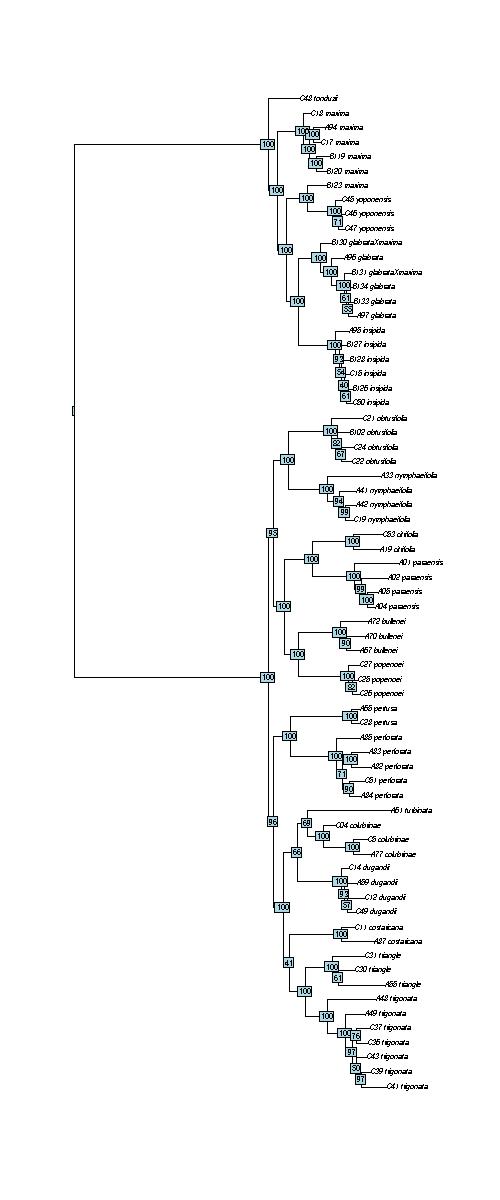

In [3]:
%%R -w 500 -h 1200
## load ape
library(ape)

## read in tree
tre <- read.tree("analysis_raxml/RAxML_bipartitions.ficus_c85d6f2_min4_s3K")

## save figure
#pdf("analysis_raxml/Ficus_c85d6f2_min4_s3K.pdf", width=6, height=12)

## ladderize and print tree
ltre <- ladderize(tre)
plot(ltre, cex=0.7)
nodelabels(ltre$node.label, cex=0.7)

## close figure
#dev.off()

In [16]:
def getarray(locifile, tree, split1=0, split2=0):
    """ parse the loci list and return a presence/absence matrix ordered by 
        the tips on the tree"""
    ## parse the loci file
    loci = open(locifile).read().split("\n//")[:-1]
    ## order (ladderize) the tree
    tree.ladderize()
    
    ## get tip names
    snames = tree.get_leaf_names()
    
    ## make empty matrix
    lxs = np.zeros((len(snames), len(loci)))
    
    ## fill the matrix
    for loc in xrange(len(loci)):
        for seq in loci[loc].split("\n"):
            if "//" not in seq:
                lxs[snames.index(seq.split()[0][1:]), loc] += 1

    return lxs

In [12]:
def countmatrix(lxsabove, lxsbelow, max=0):
    """ fill a matrix with pairwise data sharing
        between each pair of samples. You could put
        in two different 'share' matrices to have
        different results above and below the diagonal.
        Can enter a max value to limit fill along diagonal.
        """
    share = np.zeros((lxsabove.shape[0], 
                      lxsbelow.shape[0]))
    ## fill above
    names = range(lxsabove.shape[0])
    for row in lxsabove:
        for samp1,samp2 in itertools.combinations(names,2):
            shared = lxsabove[samp1, lxsabove[samp2,]>0].sum()
            share[samp1,samp2] = shared
    ## fill below
    for row in lxsbelow:
        for samp2,samp1 in itertools.combinations(names,2):
            shared = lxsabove[samp1, lxsabove[samp2,]>0].sum()
            share[samp1,samp2] = shared
    ## fill diagonal
    if not max:
        for row in range(len(names)):
            share[row,row] = lxsabove[row,].sum()
    else:
        for row in range(len(names)):
            share[row,row] = max
    return share

### Plot data sharing

In [31]:
import ete3
import numpy as np
import itertools

## reload the ipyrad Assembly if necessary
sub4 = ip.load_json("analysis_ipyrad/ficus_c85d6f2_min4_s3K.json")

## load the tree that we just inferred
tree = ete3.Tree("analysis_raxml/RAxML_bestTree.ficus_c85d6f2_min4_s3K")
tree.ladderize()
names = tree.get_leaf_names()

## parse the loci file
locidata = open(sub4.outfiles.loci)
loci = locidata.read().split("|\n")[:-1]

  loading Assembly: ficus_c85d6f2_min4_s3K
  from saved path: ~/Documents/Ficus/analysis_ipyrad/ficus_c85d6f2_min4_s3K.json


In [14]:
lxs = getarray(loci, tree)
print lxs.shape
print lxs.sum()



(69, 88656)
1771355.0


In [15]:
share = countmatrix(lxs, lxs)
print share.shape
print share

(69, 69)
[[ 37577.  32763.  26056. ...,  18316.   7295.  17782.]
 [ 32763.  37920.  27593. ...,  18040.   7124.  17332.]
 [ 26056.  27593.  29993. ...,  14896.   6193.  14502.]
 ..., 
 [ 18316.  18040.  14896. ...,  35193.  11742.  30095.]
 [  7295.   7124.   6193. ...,  11742.  13495.  11669.]
 [ 17782.  17332.  14502. ...,  30095.  11669.  33991.]]


In [116]:
import toyplot
import toyplot.html

## get a good color map
colormap = toyplot.color.LinearMap(toyplot.color.brewer.palette("Spectral"), 
                                   domain_min=share.min(), 
                                   domain_max=share.max())

In [121]:
def plotshare(share, names):
    
    ## set up canvas
    canvas = toyplot.Canvas(width=900, height=700)
    
    ## order for data
    table = canvas.matrix((share, colormap), 
                          bounds=(50, 600, 50, 600), 
                          step=5, tshow=False, lshow=False)
    
    ## put a box around it
    table.body.grid.vlines[...,[0,-1]] = 'single'
    table.body.grid.hlines[[0,-1],...] = 'single'
    
    ## make floater for grid
    for i,j in itertools.product(range(len(share)), repeat=2):
        table.body.cell(i,j).title='%s, %s : %s' % (names[i],
                                                    names[j],
                                                    int(share[i,j]))
    ## canvas for barplot
    axes = canvas.cartesian(bounds=(665, 800, 90, 560))
    ## make floater for barplot
    zf = zip(names[::-1], share.diagonal()[::-1])
    barfloater = ["%s: %s" % (i,int(j)) for i,j in zf]
    
    ## create barplot
    axes.bars(share.diagonal()[::-1], 
              along="y",
              title = barfloater)
        
    ## Hide yspine, move labels to the left, 
    ## use taxon names, rotate angle, align.
    axes.y.spine.show = False
    axes.y.ticks.labels.offset = 0
    axes.y.ticks.locator = toyplot.locator.Explicit(range(len(names)),
                                           labels=names[::-1])
    axes.y.ticks.labels.angle = -90
    axes.y.ticks.labels.style = {"baseline-shift":0,
                                 "text-anchor":"end",
                                 "font-size":"8px"} 
        
    ## Rotate xlabels, align with ticks, 
    ## change to thousands, move up on canvas,
    ## show ticks, and hide popup coordinates
    axes.x.ticks.labels.angle = 90
    axes.x.ticks.labels.offset = 20
    axes.x.ticks.locator = toyplot.locator.Explicit(
        range(0, 40000, 5000), 
        ["{}K".format(i) for i in range(0, 40, 5)])
    axes.x.ticks.labels.style = {"baseline-shift":0, 
                                 "text-anchor":"end", 
                                 "-toyplot-anchor-shift":"15px"}
    axes.x.ticks.show = True
    
    ## add labels
    label_style = {"font-size": "16px", "font-weight": "bold"}
    canvas.text(300, 60, "(a) Matrix of shared RAD loci", style=label_style)
    canvas.text(700, 60, "(b) N RAD loci per sample", style=label_style)

    
    ## add colormap
    #canvas.color_scale(colormap)
    
    ## save as html
    #toyplot.html.render(canvas, "c85d5f2_min4_s3k_datasharing.html")
    
    
plotshare(share, names)

C48_tonduzii, C48_tonduzii : 37577 C48_tonduzii, C18_maxima : 32763 C48_tonduzii, B120_maxima : 26056 C48_tonduzii, B119_maxima : 23105 C48_tonduzii, C17_maxima : 32423 C48_tonduzii, A94_maxima : 24295 C48_tonduzii, B123_maxima : 19439 C48_tonduzii, C45_yoponensis : 32150 C48_tonduzii, C47_yoponensis : 31429 C48_tonduzii, C46_yoponensis : 31864 C48_tonduzii, A95_insipida : 13260 C48_tonduzii, B127_insipida : 23742 C48_tonduzii, B128_insipida : 30313 C48_tonduzii, C15_insipida : 30316 C48_tonduzii, C50_insipida : 31150 C48_tonduzii, B126_insipida : 30622 C48_tonduzii, B130_glabrataXmaxima : 30070 C48_tonduzii, A96_glabrata : 26885 C48_tonduzii, B131_glabrataXmaxima : 30818 C48_tonduzii, B134_glabrata : 29904 C48_tonduzii, A97_glabrata : 19701 C48_tonduzii, B133_glabrata : 28107 C48_tonduzii, A33_nymphaeifolia : 1551 C48_tonduzii, A41_nymphaeifolia : 13234 C48_tonduzii, C19_nymphaeifolia : 18209 C48_tonduzii, A42_nymphaeifolia : 17894 C48_tonduzii, C21_obtusifolia : 1753 C48_tonduzii, B102_obtusifolia : 17952 C48_tonduzii, C22_obtusifolia : 18537 C48_tonduzii, C24_obtusifolia : 17491 C48_tonduzii, C27_popenoei : 10455 C48_tonduzii, C26_popenoei : 17547 C48_tonduzii, C25_popenoei : 18486 C48_tonduzii, A72_bullenei : 1886 C48_tonduzii, A67_bullenei : 8572 C48_tonduzii, A70_bullenei : 5992 C48_tonduzii, A19_citrifolia : 3884 C48_tonduzii, C53_citrifolia : 2299 C48_tonduzii, A01_paraensis : 2187 C48_tonduzii, A02_paraensis : 4886 C48_tonduzii, A04_paraensis : 18262 C48_tonduzii, A05_paraensis : 7035 C48_tonduzii, C28_pertusa : 18401 C48_tonduzii, A65_pertusa : 18542 C48_tonduzii, A85_perforata : 11184 C48_tonduzii, A84_perforata : 18261 C48_tonduzii, C51_perforata : 18753 C48_tonduzii, A82_perforata : 11888 C48_tonduzii, A83_perforata : 12033 C48_tonduzii, C14_dugandii : 18301 C48_tonduzii, A59_dugandii : 15246 C48_tonduzii, C49_dugandii : 16580 C48_tonduzii, C12_dugandii : 4885 C48_tonduzii, A61_turbinata : 2880 C48_tonduzii, C04_colubrinae : 16896 C48_tonduzii, A77_colubrinae : 15250 C48_tonduzii, C5_colubrinae : 18432 C48_tonduzii, A87_costaricana : 1484 C48_tonduzii, C11_costaricana : 17920 C48_tonduzii, C31_triangle : 8459 C48_tonduzii, A55_triangle : 3772 C48_tonduzii, C30_triangle : 19010 C48_tonduzii, A48_trigonata : 3368 C48_tonduzii, A49_trigonata : 3931 C48_tonduzii, C36_trigonata : 18332 C48_tonduzii, C37_trigonata : 18114 C48_tonduzii, C43_trigonata : 18316 C48_tonduzii, C41_trigonata : 7295 C48_tonduzii, C39_trigonata : 17782 C18_maxima, C48_tonduzii : 32763 C18_maxima, C18_maxima : 37920 C18_maxima, B120_maxima : 27593 C18_maxima, B119_maxima : 24189 C18_maxima, C17_maxima : 34844 C18_maxima, A94_maxima : 25812 C18_maxima, B123_maxima : 20040 C18_maxima, C45_yoponensis : 32253 C18_maxima, C47_yoponensis : 31735 C18_maxima, C46_yoponensis : 32033 C18_maxima, A95_insipida : 13207 C18_maxima, B127_insipida : 24153 C18_maxima, B128_insipida : 30715 C18_maxima, C15_insipida : 30760 C18_maxima, C50_insipida : 31154 C18_maxima, B126_insipida : 30981 C18_maxima, B130_glabrataXmaxima : 31234 C18_maxima, A96_glabrata : 27621 C18_maxima, B131_glabrataXmaxima : 31462 C18_maxima, B134_glabrata : 30396 C18_maxima, A97_glabrata : 20069 C18_maxima, B133_glabrata : 28853 C18_maxima, A33_nymphaeifolia : 1473 C18_maxima, A41_nymphaeifolia : 12851 C18_maxima, C19_nymphaeifolia : 17808 C18_maxima, A42_nymphaeifolia : 17392 C18_maxima, C21_obtusifolia : 1666 C18_maxima, B102_obtusifolia : 17756 C18_maxima, C22_obtusifolia : 18261 C18_maxima, C24_obtusifolia : 16846 C18_maxima, C27_popenoei : 10199 C18_maxima, C26_popenoei : 17043 C18_maxima, C25_popenoei : 18174 C18_maxima, A72_bullenei : 1819 C18_maxima, A67_bullenei : 8318 C18_maxima, A70_bullenei : 5863 C18_maxima, A19_citrifolia : 3779 C18_maxima, C53_citrifolia : 2213 C18_maxima, A01_paraensis : 2069 C18_maxima, A02_paraensis : 4693 C18_maxima, A04_paraensis : 17859 C18_maxima, A05_paraensis : 6899 C18_maxima, C28_pertusa : 18148 C18_maxima, A65_pertusa : 18147 C18_maxima, A85_perfora

### Analyze admixture (f4/D/ABBA-BABA) from site patterns in tetrad database

In [ ]:
## ...